In [87]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from lifetimes import BetaGeoFitter
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes import GammaGammaFitter

import matplotlib.pyplot as plt
import datetime as dt

In [88]:
df = pd.read_csv("online retail.csv",encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom


The following terminology is used for CLV models: <br><br>
Frequency represents the number of repeat purchases made by the customer. This means it is less than the total number of purchases. <br><br>
T represents the age of the customer in any selected time unit. This is equal to the time between a customer’s first purchase and the end of the period worked. <br><br>
Recency represents the age at which the customer made their most recent purchase. This is equal to the time between a customer’s first purchase and their last purchase. (Therefore, if they made only 1 purchase, the recency is 0.)

calibration_and_holdout_data : This function creates a summary of each customer over a calibration and holdout period (training and testing, respectively). <br>
calibration_period_end: is a period to limit the calibration. <br>
freq: Default ‘D’ for days. Other examples: ‘W’ for weekly. <br>

In [89]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]
print(df.head())
print(df.shape)
print(df['CustomerID'].nunique())



   CustomerID InvoiceDate  Sales
0     17850.0  2010-01-12  15.30
1     17850.0  2010-01-12  20.34
2     17850.0  2010-01-12  22.00
3     17850.0  2010-01-12  20.34
4     17850.0  2010-01-12  20.34
(397924, 3)
4339


In [90]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-09')
print(df.shape,data.shape)
data.head()


(397924, 3) (4333, 4)


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,476.0,515.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4333.000000
mean        2.852527
std         5.933511
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       130.000000
Name: frequency, dtype: float64
0.35771982460189244


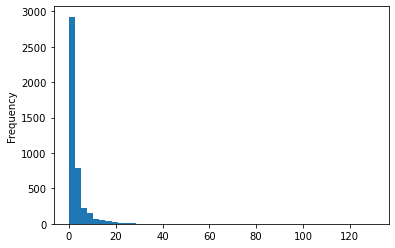

In [91]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

Among all customers in our data, more than 35% of them only made purchase once (no repeat).

<h2> Frequency/Recency Analysis Using the BG/NBD Model

In [92]:
bgf = BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4333 subjects, a: 0.00, alpha: 74.93, b: 0.00, r: 0.73>


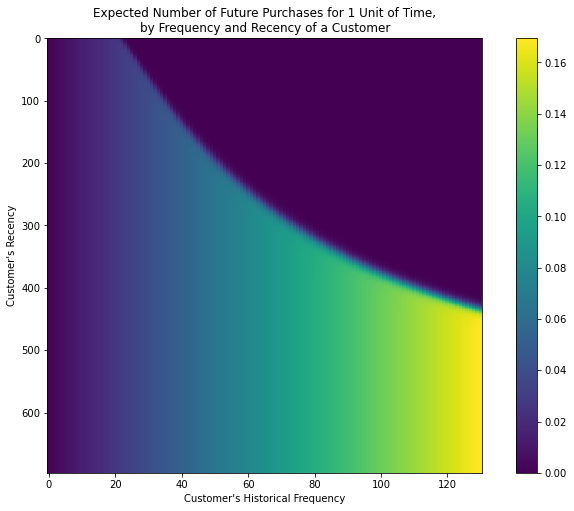

In [93]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

If a customer has made 120 purchases, and his latest purchase was when he was approximately 350 days old (i.e. Recency: the duration between her first transaction and her latest transaction is 350 days), then he is our best customer (bottom-right). <br><br>
Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them. <br><br>
Customers who have purchased a lot but not recently (top-right corner), have probably gone. <br><br>
There are also another type of customers that around (40, 300) that represents the customer who buys infrequently, and we have not seen him recently, so he might buy again. However, we are not sure if he has gone or just between purchases.

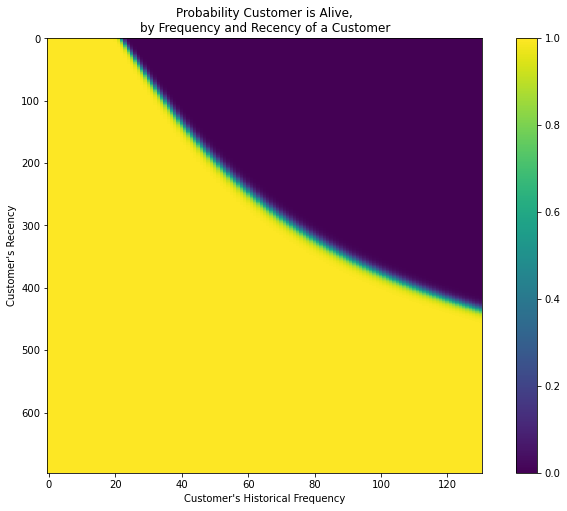

In [94]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Customers who have purchased recently are almost surely “alive”. <br><br>
Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right. <br><br>
We are ranking customers from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history. <br><br>

In [95]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,692.0,696.0,135.890114,0.115093
15311.0,88.0,688.0,696.0,671.460227,0.115093
17841.0,110.0,694.0,696.0,362.595727,0.143630
12748.0,113.0,692.0,696.0,298.360885,0.147522
14911.0,130.0,695.0,696.0,1088.284385,0.169573


Listed above are our top 5 customers that the model expects them to make purchases in the next day. The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.

<h3> Assessing model fit

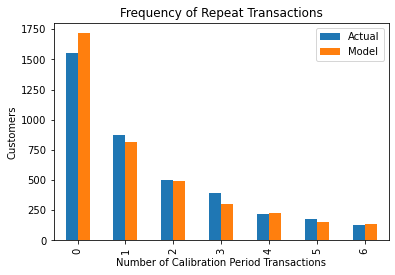

In [96]:
plot_period_transactions(bgf)

We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

In [97]:
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-09' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        211.0  331.0                4.0   
12348.0               2.0        139.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               4.0         78.0  156.0                2.0   

            duration_holdout  
CustomerID                    
12346.0                184.0  
12347.0                184.0  
12348.0                184.0  
12350.0                184.0  
12352.0                184.0  


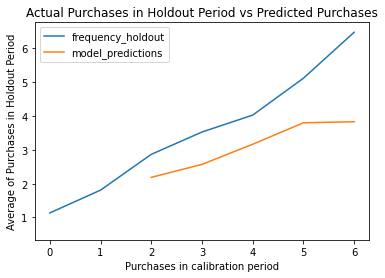

In [98]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period. The sample period consists the beginning to 2011–06–08; the validation period spans from 2011–06–09 to 2011–12–09. The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The green and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to very accurately predict the customer base’s behaviour out of the sample, the model under-estimates at 4 purchases and after 5 purchases.

<h2> Customer transactions predictions

In [99]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.11343552329791275

<h2> Customer probability histories

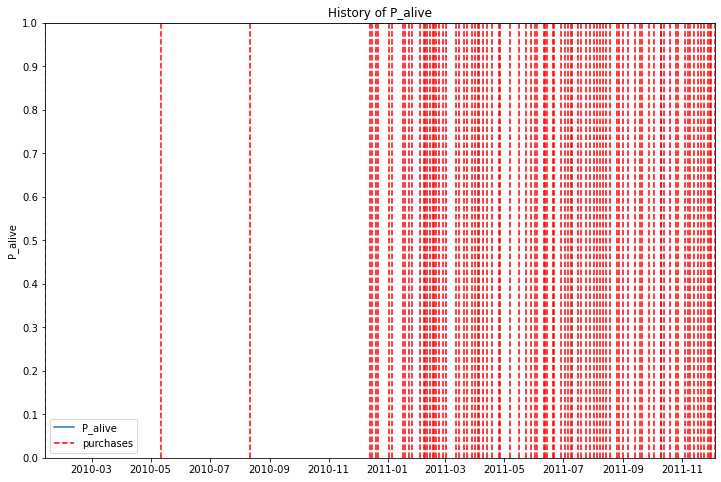

In [100]:
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

Our best customer is definitely alive, however, he had several hiatus in the second half of the year 2011.

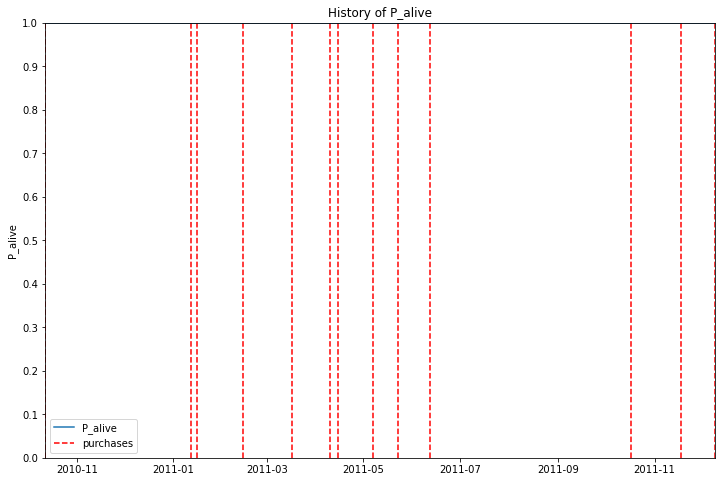

In [102]:
fig = plt.figure(figsize=(12,8))
id = 12989
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

<h2> Estimating customer lifetime value using gamma-gamma model of monetary value

We are now taking into account the economic value of each transaction. To estimate this we use the Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton, to predict likely spend per transaction in the future at the customer level.

In [103]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    476.0  515.0      599.701667             0.011406
12348.0           3.0    283.0  358.0      301.480000             0.008613
12352.0           6.0    268.0  340.0      253.565000             0.016217
12356.0           2.0    303.0  325.0      269.905000             0.006824
12358.0           1.0    117.0  119.0      484.860000             0.008915
2783


In [104]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2783 subjects, p: 2.30, q: 3.42, v: 447.68>


In [105]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    424.940906
12347.0    573.599246
12348.0    333.567797
12349.0    424.940906
12350.0    424.940906
12352.0    279.161856
12353.0    424.940906
12354.0    424.940906
12355.0    424.940906
12356.0    323.395208
dtype: float64
